# Sarcasm Detector

This notebook analyses news headlines published by Huffington post and The Onion. The objective of this notebook is to employ various natural language processing techniques to classify headlines as either sarcastic or not sarcastic. 

# Data 

The dataset contains three columns: 

- is_sarcastic : 1 for sarcastic and 0 for not sarcastic

- headline : headline of the article

- article_link : Link to the original news article


# Methodology

Tasks include exploratory data analysis, data preprocessing and predictive modelling. 

# Import Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import re
import random
import nltk
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Get the big guns up and running !
GPU = tf.config.experimental.list_physical_devices('GPU')
print("Graphics Processing Unit: ", len(GPU))

Graphics Processing Unit:  1


In [3]:
df = pd.read_json("Sarcasm_Headlines_Dataset.json", lines = True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


# 1. Exploratory Data Analysis

Data types and shape of the dataset

In [4]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


(None, (26709, 3))

**1. Target Variable**

- Lets take a look at the distribution of the sarcastic vs non sarcastic articles.

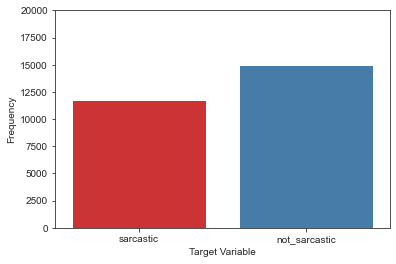

Proportion of sarcastic headlines:  56.1 %
Proportion of normal headlines: 43.9 %


In [5]:
# Lets create a barchart of the response variable
df['target'] = df['is_sarcastic'].map({1: 'sarcastic', 0: 'not_sarcastic'})
sns.set_style('ticks')
sns.countplot(data=df, x="target", order=["sarcastic", "not_sarcastic"], palette='Set1')
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.ylim([0, 20000])
plt.show()


# Proportion of positive vs negative reviews
x = df['target'].value_counts(normalize=True)
print("Proportion of sarcastic headlines: ", (x['not_sarcastic'] * 100).round(2), '%')
print("Proportion of normal headlines:", (x['sarcastic'].round(3) * 100), '%')

- The target variable is approximately balanced.

**2. News Headlines**

- Lets take a look at some headlines

In [6]:
list(df['headline'][10:20])

['airline passengers tackle man who rushes cockpit in bomb threat',
 'facebook reportedly working on healthcare features and apps',
 "north korea praises trump and urges us voters to reject 'dull hillary'",
 "actually, cnn's jeffrey lord has been 'indefensible' for a while",
 'barcelona holds huge protest in support of refugees',
 "nuclear bomb detonates during rehearsal for 'spider-man' musical",
 "cosby lawyer asks why accusers didn't come forward to be smeared by legal team years ago",
 'stock analysts confused, frightened by boar market',
 "bloomberg's program to build better cities just got bigger",
 'craig hicks indicted']

Lets plot a wordmap to visualize the most frequently used words.

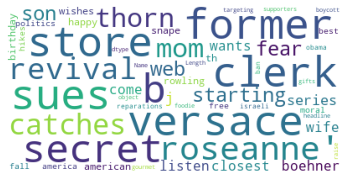

In [7]:
wc = wordcloud.WordCloud(background_color='white', max_words=300,  max_font_size=50)
wc = wc.generate(str(df.headline))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

- The dataset is reasonably clean. However we still need to perform some preprocessing techiques before passing the features to the modelling phase.

# 2. Data Preprocessing

1. Remove punctuation marks, special characters and stopwords.

2. Lowercase letters

3. Perform Lemmatization

4. Perform Tokenization 

5. Perform Padding

5. Split the dataset into training and testing

In [8]:
# This section performs the first three preprocessing tasks
sentences = []
for i in range(len(df)):
    headline = re.sub('[^a-zA-Z]', ' ', df.headline[i])  
    headline = headline.lower()
    headline = headline.split() 
    lem = WordNetLemmatizer() 
    headline = [lem.lemmatize(word) for word in headline if word not in set(stopwords.words('english'))] 
    headline = ' '.join(headline) 
    sentences.append(headline)  

  - Lets take a look at the transformed features. Till now I have only performed the first three preprocessing tasks.

In [9]:
# Transformed Headlines
sentences[10:20]

['airline passenger tackle man rush cockpit bomb threat',
 'facebook reportedly working healthcare feature apps',
 'north korea praise trump urge u voter reject dull hillary',
 'actually cnn jeffrey lord indefensible',
 'barcelona hold huge protest support refugee',
 'nuclear bomb detonates rehearsal spider man musical',
 'cosby lawyer asks accuser come forward smeared legal team year ago',
 'stock analyst confused frightened boar market',
 'bloomberg program build better city got bigger',
 'craig hick indicted']

In [10]:
# Training and testing sentences
X_train = np.array(sentences[0:20000])
X_test = np.array(sentences[20000:])

# Training and testing labels
y_train = np.array(df['is_sarcastic'][0:20000])
y_test = np.array(df['is_sarcastic'][20000:])

In [11]:
# Shape of datasets
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((20000,), (20000,), (6709,), (6709,))

 - I will employ keras' tokenizer API to tokenize each word, apply padding and create a sequence of vectorized numbers that map the actual sentences.

In [12]:
# Tokenize words
vocab_size = 10000
oov_tok = "<OOV>"

# Instantiate tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Transform words to tokens
tokenizer.fit_on_texts(X_train)

# Dictionary of keys for words and values for their numerical encoding
tokenizer.word_index

# Represent the tokenized words as sequences of numbers that map to sentences
ordered_training = tokenizer.texts_to_sequences(X_train)

# Tokenize and order testing set
ordered_testing = tokenizer.texts_to_sequences(X_test)

In [13]:
# Lets take a look at the vectorized sentences
ordered_training[0:10]

[[264, 1, 591, 2641, 1158, 231, 46, 1550, 2089, 4991],
 [5983, 2858, 1326, 1, 303, 2642, 178, 797],
 [51, 820, 477, 136, 2090, 512, 4992, 29, 3806],
 [1072, 38, 265, 1400, 88, 1956, 1267, 4297, 220],
 [628, 478, 3807, 490, 7578, 527, 451, 1159, 21],
 [7579, 25, 5],
 [5984, 222, 419, 3116, 1754, 1221],
 [420, 977, 55, 41, 72, 162],
 [166, 2859, 3808, 348, 7580, 1755, 80],
 [732, 242, 203, 307, 2, 1, 328]]

In [14]:
# Textual headline vs its vectorized counterpart
print(f'Head line: {df.headline[5]}  \nVectorized headline : {ordered_training[5]}')

Head line: advancing the world's women  
Vectorized headline : [7579, 25, 5]


 - Apply padding to maintain the feature length of the longest sentence

In [15]:
# Padding train set
max_length = 100
padding_type='post'
trunc_type='post'


# Pad training set
training_padded = pad_sequences(ordered_training, 
                                maxlen=max_length,
                                padding=padding_type,
                                truncating=trunc_type)



# Padding test set
testing_padded = pad_sequences(ordered_testing,
                               maxlen=max_length,
                               padding=padding_type,
                               truncating=trunc_type)

In [16]:
X_train = np.array(training_padded)
y_train = np.array(y_train)
X_test = np.array(testing_padded)
y_test = np.array(y_test)

# 4. Modelling

At this stage we will deploy LSTM and bidirectional LSTM's using tensorflow and keras.

**1. Recurrent Neural Network**

In [17]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                204       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 13        
Total params: 160,217
Trainable params: 160,217
Non-trainable params: 0
_________________________________________________________________


In [19]:
num_epochs = 10
history = model.fit(X_train,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(X_test, y_test), 
                    callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True)],
                    verbose=2)

Epoch 1/10
625/625 - 3s - loss: 0.6862 - accuracy: 0.5588 - val_loss: 0.6827 - val_accuracy: 0.5633
Epoch 2/10
625/625 - 2s - loss: 0.6752 - accuracy: 0.5639 - val_loss: 0.6509 - val_accuracy: 0.5984
Epoch 3/10
625/625 - 2s - loss: 0.5838 - accuracy: 0.7208 - val_loss: 0.5397 - val_accuracy: 0.7609
Epoch 4/10
625/625 - 2s - loss: 0.4659 - accuracy: 0.8024 - val_loss: 0.4785 - val_accuracy: 0.7804
Epoch 5/10
625/625 - 2s - loss: 0.3976 - accuracy: 0.8324 - val_loss: 0.4668 - val_accuracy: 0.7767
Epoch 6/10
625/625 - 3s - loss: 0.3560 - accuracy: 0.8498 - val_loss: 0.4483 - val_accuracy: 0.7912
Epoch 7/10
625/625 - 2s - loss: 0.3253 - accuracy: 0.8662 - val_loss: 0.4385 - val_accuracy: 0.7971
Epoch 8/10
625/625 - 2s - loss: 0.3006 - accuracy: 0.8744 - val_loss: 0.4391 - val_accuracy: 0.8027
Epoch 9/10
625/625 - 3s - loss: 0.2807 - accuracy: 0.8849 - val_loss: 0.4465 - val_accuracy: 0.7955
Epoch 10/10
625/625 - 2s - loss: 0.2626 - accuracy: 0.8932 - val_loss: 0.4464 - val_accuracy: 0.8012

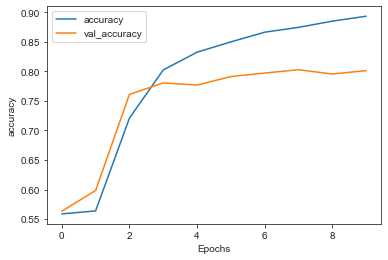

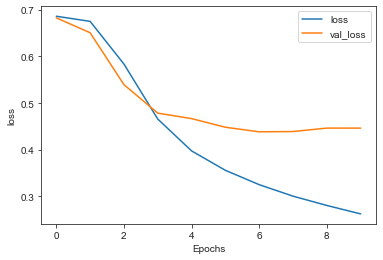

In [20]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
  

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**2. Bidirectional LSTM-RNN**

In [21]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(1, activation = 'sigmoid')])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 64)           12544     
_________________________________________________________________
dense_2 (Dense)              (None, 100, 64)           4160      
_________________________________________________________________
dropout (Dropout)            (None, 100, 64)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 100, 1)            65        
Total params: 176,769
Trainable params: 176,769
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [24]:
num_epochs = 10
history = model.fit(X_train,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(X_test, y_test),
                    verbose=2,
                   callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True)])

Epoch 1/10
625/625 - 12s - loss: 0.6583 - accuracy: 0.6153 - val_loss: 0.6317 - val_accuracy: 0.6358
Epoch 2/10
625/625 - 8s - loss: 0.5048 - accuracy: 0.7798 - val_loss: 0.5791 - val_accuracy: 0.6592
Epoch 3/10
625/625 - 8s - loss: 0.4586 - accuracy: 0.7911 - val_loss: 0.5762 - val_accuracy: 0.6691
Epoch 4/10
625/625 - 8s - loss: 0.4280 - accuracy: 0.8177 - val_loss: 0.5683 - val_accuracy: 0.7370
Epoch 5/10
625/625 - 8s - loss: 0.3720 - accuracy: 0.8599 - val_loss: 0.5656 - val_accuracy: 0.7469
Epoch 6/10
625/625 - 9s - loss: 0.3305 - accuracy: 0.8863 - val_loss: 0.5826 - val_accuracy: 0.7559
Epoch 7/10
625/625 - 9s - loss: 0.3285 - accuracy: 0.8846 - val_loss: 0.5974 - val_accuracy: 0.7283
Epoch 8/10
625/625 - 9s - loss: 0.3001 - accuracy: 0.9038 - val_loss: 0.6212 - val_accuracy: 0.7742


In [25]:
# Confusion Matrix & Classification Report

def evaluate_model(model, X_test):
    
    y_pred = model.predict(X_test)
    y_pred = y_pred[:, 0]
    y_pred = y_pred.round()
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred, target_names=["sarcastic", "not_sarcastic"])
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.6, labels=["sarcastic", "not_sarcastic"])
    plt.yticks(ticks=np.arange(2) + 0.6, labels=["sarcastic", "not_sarcastic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Testing Accuracy:", accuracy_score(y_test, y_pred).round(3) * 100, "%")
    print("\nClassification Report for LSTM-RNN :\n----------------------------------\n", clr)

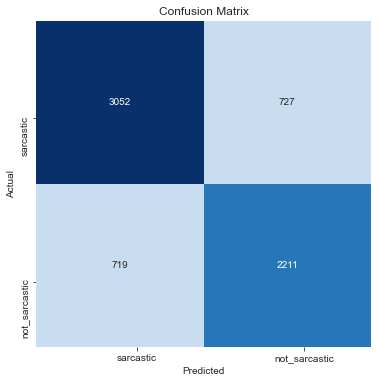

Testing Accuracy: 78.4 %

Classification Report for LSTM-RNN :
----------------------------------
                precision    recall  f1-score   support

    sarcastic       0.81      0.81      0.81      3779
not_sarcastic       0.75      0.75      0.75      2930

     accuracy                           0.78      6709
    macro avg       0.78      0.78      0.78      6709
 weighted avg       0.78      0.78      0.78      6709



In [26]:
evaluate_model(model, X_test)

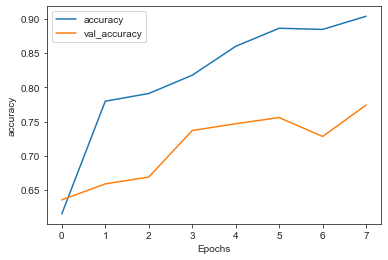

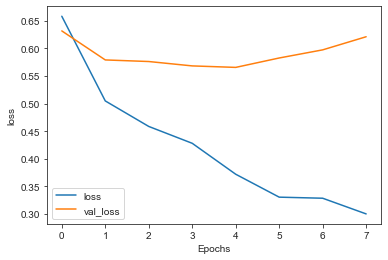

In [27]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Conclusion

Both models seem to experience some overfitting. It would be worth applying regularization techniques and try other textual preprocessing to achieve better results. For now I will conclude the analysis here.